In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy.io as sio
import librosa

import time

import skimage
import skimage.io
from skimage.transform import rescale

from scipy.io import wavfile
import os
import subprocess

import sys
sys.path.append("../src")
from spectrogramtools import *
from stego import *
from swpowerstego import *
from imtools import *
from tsp import *
from curvature import *


In [2]:
# Image parameters
thresh = 0.1
p = 1
canny_sigma = 3
density_fac= 1
edge_weight = 10
target_points = 2000

np.random.seed(0)
I = skimage.io.imread("../data/images/usher.jpg")

X = voronoi_stipple(I, thresh, target_points=target_points, p=p, canny_sigma=canny_sigma, edge_weight=edge_weight, n_iters=10, do_plot=False)

0
535
1106
1614


## Curvature Shortening Figure

In [3]:
X = get_tsp_tour(X)

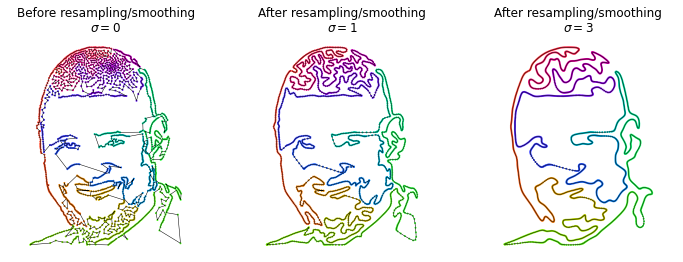

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], s=1, c=sinebow(np.linspace(0, 1, X.shape[0])), cmap='RdBu', zorder=1)
plt.plot(X[:, 0], X[:, 1], 'k', linewidth=0.5)
plt.axis("equal")
plt.axis("off")
plt.title("Before resampling/smoothing\n$\\sigma=0$")

sigma = 1
s = get_arclen(get_curv_vectors(X, 0, sigma, loop=True)[1])
X1 = arclen_resample(X, s, X.shape[0])
sigma = 1
X1 = get_curv_vectors(X1, 0, sigma, loop=True)[0]
plt.subplot(132)
plt.scatter(X1[:, 0], X1[:, 1], s=1, c=sinebow(np.linspace(0, 1, X1.shape[0])), cmap='RdBu', zorder=1)
plt.plot(X1[:, 0], X1[:, 1], 'k', linewidth=0.5)
plt.axis("equal")
plt.axis("off")
plt.title("After resampling/smoothing\n$\\sigma={}$".format(sigma))


sigma = 3
s = get_arclen(get_curv_vectors(X, 0, sigma, loop=True)[1])
X2 = arclen_resample(X, s, X.shape[0])
X2 = get_curv_vectors(X2, 0, sigma, loop=True)[0]
plt.subplot(133)
plt.scatter(X2[:, 0], X2[:, 1], s=1, c=sinebow(np.linspace(0, 1, X2.shape[0])), cmap='RdBu', zorder=1)
plt.plot(X2[:, 0], X2[:, 1], 'k', linewidth=0.5)
plt.axis("equal")
plt.axis("off")
plt.title("After resampling/smoothing\n$\\sigma={}$".format(sigma))
plt.savefig("CurvatureShortening.svg", bbox_inches='tight')

X = X1

## Lambda Tradeoff Figure

/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  3
Computing target coordinate 1 of 2...

Elapsed time: 10.105
Computing target coordinate 2 of 2...

Elapsed time: 2.852


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  3
Computing target coordinate 1 of 2...

Elapsed time: 1.114
Computing target coordinate 2 of 2...

Elapsed time: 0.945


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  3
Computing target coordinate 1 of 2...

Elapsed time: 0.158
Computing target coordinate 2 of 2...

Elapsed time: 0.140


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


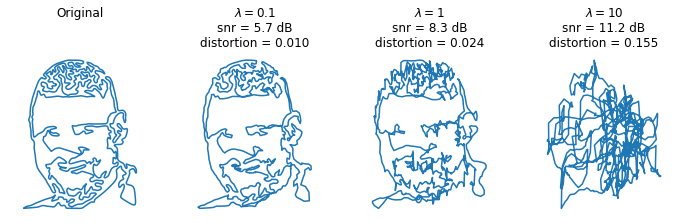

In [5]:
# Audio parameters
x, sr = librosa.load("../data/tunes/usher-baby.mp3", sr=44100)
win_length = 1024
mag_idxs = [1, 2]
phase_idxs = mag_idxs

# Sliding window parameters
win = 16


fit_lams = [0.1, 1, 10]
K = len(fit_lams)+1
res = 3

plt.figure(figsize=(res*K, res))
plt.subplot(1, K, 1)
plt.plot(X[:, 0], X[:, 1])
plt.axis("equal")
plt.title("Original\n\n")
plt.axis("off")

q = -1
for k, fit_lam in enumerate(fit_lams):
    sp = STFTPowerDisjoint(x, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=True)
    sp.solve()
    
    y = sp.reconstruct_signal()

    prefix = "SpecPower_Win{}_fit{:.3g}_stftwin{}".format(win, fit_lam, win_length)
    filename = "{}.mp3".format(prefix)
    wavfile.write("out.wav", sr, y)
    if os.path.exists(filename):
        os.remove(filename)
    subprocess.call("ffmpeg -i out.wav".split() + [filename], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    os.remove("out.wav")

    z, sr = librosa.load(filename, sr=sr)
    z_sp = STFTPowerDisjoint(z, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=False)
    z_sp.MagSolver.targets = sp.MagSolver.targets
    Z = z_sp.get_signal(normalize=True)
    snr = get_snr(x, z)
    distortion = z_sp.get_distortion()[0]
    title = "$\\lambda={}$\nsnr = {:.1f} dB\ndistortion = {:.3f}".format(fit_lam, snr, distortion,)
    plt.subplot(1, K, k+2)
    plt.plot(Z[:, 0], Z[:, 1])
    plt.axis("equal")
    plt.axis("off")
    plt.title(title)
    
plt.savefig("LambdaEffect.svg", bbox_inches='tight')

## Window Length Tradeoff Figure

/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  2
Computing target coordinate 1 of 2...

Elapsed time: 0.157
Computing target coordinate 2 of 2...

Elapsed time: 0.141


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  3
Computing target coordinate 1 of 2...

Elapsed time: 13.388
Computing target coordinate 2 of 2...

Elapsed time: 2.809


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


viterbi_K =  5
Computing target coordinate 1 of 2...

Elapsed time: 16.056
Computing target coordinate 2 of 2...

Elapsed time: 16.819


/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


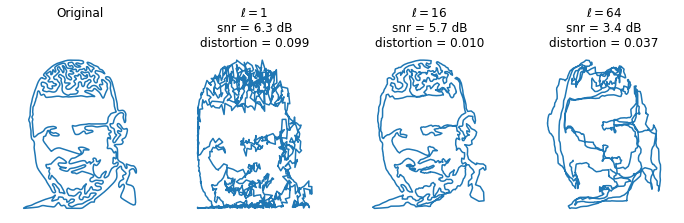

In [6]:
# Audio parameters
x, sr = librosa.load("../data/tunes/usher-baby.mp3", sr=44100)
win_length = 1024
mag_idxs = [1, 2]
phase_idxs = mag_idxs

# Sliding window parameters
wins = [1, 16, 64]
fit_lam = 0.1
K = len(wins)+1
res = 3

plt.figure(figsize=(res*K, res))
plt.subplot(1, K, 1)
plt.plot(X[:, 0], X[:, 1])
plt.axis("equal")
plt.title("Original\n\n")
plt.axis("off")

q = -1
for k, win in enumerate(wins):
    sp = STFTPowerDisjoint(x, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=True)
    sp.solve()
    
    y = sp.reconstruct_signal()

    prefix = "SpecPower_Win{}_fit{:.3g}_stftwin{}".format(win, fit_lam, win_length)
    filename = "{}.mp3".format(prefix)
    wavfile.write("out.wav", sr, y)
    if os.path.exists(filename):
        os.remove(filename)
    subprocess.call("ffmpeg -i out.wav".split() + [filename], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    os.remove("out.wav")

    z, sr = librosa.load(filename, sr=sr)
    z_sp = STFTPowerDisjoint(z, X, win_length, mag_idxs, phase_idxs, win, fit_lam, q, do_viterbi=False)
    z_sp.MagSolver.targets = sp.MagSolver.targets
    Z = z_sp.get_signal(normalize=True)
    snr = get_snr(x, z)
    distortion = z_sp.get_distortion()[0]
    title = "$\ell={}$\nsnr = {:.1f} dB\ndistortion = {:.3f}".format(win, snr, distortion,)
    plt.subplot(1, K, k+2)
    plt.plot(Z[:, 0], Z[:, 1])
    plt.axis("equal")
    plt.axis("off")
    plt.title(title)
    
plt.savefig("WindowEffect.svg", bbox_inches='tight')